<p align="center">
  <br/>
    <a href="https://stabrise.com/scaledp/"><img alt="ScaleDP" src="https://raw.githubusercontent.com/StabRise/ScaleDP/refs/heads/master/images/scaledp.webp" width="376" style="max-width: 100%;"></a>
  <br/>
</p>

<p align="center">
    <a target="_blank" href="https://colab.research.google.com/github/StabRise/scaledp-tutorials/blob/master/4.LLMNer.ipynb">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
    <a href="https://github.com/stabrise/scaledp/" alt="GitHub"><img src="https://img.shields.io/static/v1?label=GitHub&message=ScaleDP&color=blue&logo=github" /></a>
    <a href="https://pypi.org/project/scaledp/" alt="Package on PyPI"><img src="https://img.shields.io/pypi/v/scaledp.svg" /></a>    
    <a href="https://github.com/stabrise/scaledp/blob/main/LICENSE"><img alt="GitHub" src="https://img.shields.io/github/license/stabrise/scaledp.svg?color=blue"></a>
    <a href="https://stabrise.com"><img alt="StabRise" src="https://img.shields.io/badge/by-StabRise-orange.svg?style=flat&colorA=E1523D&colorB=007D8A"></a>
</p>

# Named Entity Recognition (NER) with Spark Pdf

Spark Pdf provides possibility to run NER models using HugeTransformer library. You can run NER models for text and pdf documents.
You can use any NER models from the Hugging Face model hub. You can also visualize the results of the NER models.

## Installation

In [2]:
%%bash
[[ ! "${COLAB_RELEASE_TAG}" ]] && exit
sudo apt install tesseract-ocr

In [ ]:
!pip install scaledp[ml]

## Start Spark Session with ScaleDP

In [2]:
from scaledp import *
import os

os.environ["OPENAI_API_KEY"] = "your_key"
os.environ["OPENAI_BASE_URL"] = 'https://generativelanguage.googleapis.com/v1beta/'

spark = ScaleDPSession()
spark

## Read Text

In [4]:
df = spark.read.text("./data/texts/example.txt", wholetext=True)
df.show(1, False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Show text

In [5]:
df.show_text()

Id:,0


## Run Ner for Text document

In [7]:
pipeline = PipelineModel(stages=[
    TextToDocument(),
    LLMNer()
])
result = pipeline.transform(df).cache()

result.show_ner("ner")

[Stage 6:>                                                          (0 + 1) / 1]

+------------+-----+-------------------+-----+---+-----+
|entity_group|score|               word|start|end|boxes|
+------------+-----+-------------------+-----+---+-----+
|      PERSON|  0.0|         Sam Altman|    0|  0|   []|
|ORGANIZATION|  0.0|             OpenAI|    0|  0|   []|
|    LOCATION|  0.0|      San Francisco|    0|  0|   []|
|        DATE|  0.0|   October 21, 2024|    0|  0|   []|
|ORGANIZATION|  0.0|Stanford University|    0|  0|   []|
|ORGANIZATION|  0.0|                MIT|    0|  0|   []|
|ORGANIZATION|  0.0|          Microsoft|    0|  0|   []|
|ORGANIZATION|  0.0|             Amazon|    0|  0|   []|
|ORGANIZATION|  0.0|             Google|    0|  0|   []|
|      PERSON|  0.0|      Sundar Pichai|    0|  0|   []|
|      PERSON|  0.0|     Dr. Jane Smith|    0|  0|   []|
|ORGANIZATION|  0.0| Harvard University|    0|  0|   []|
+------------+-----+-------------------+-----+---+-----+



# Run Ner for Pdf document

## Read Pdf file

Image#:,0
Path:,example.pdf
Size:,2484 x 3509 px
Resolution:,300 dpi

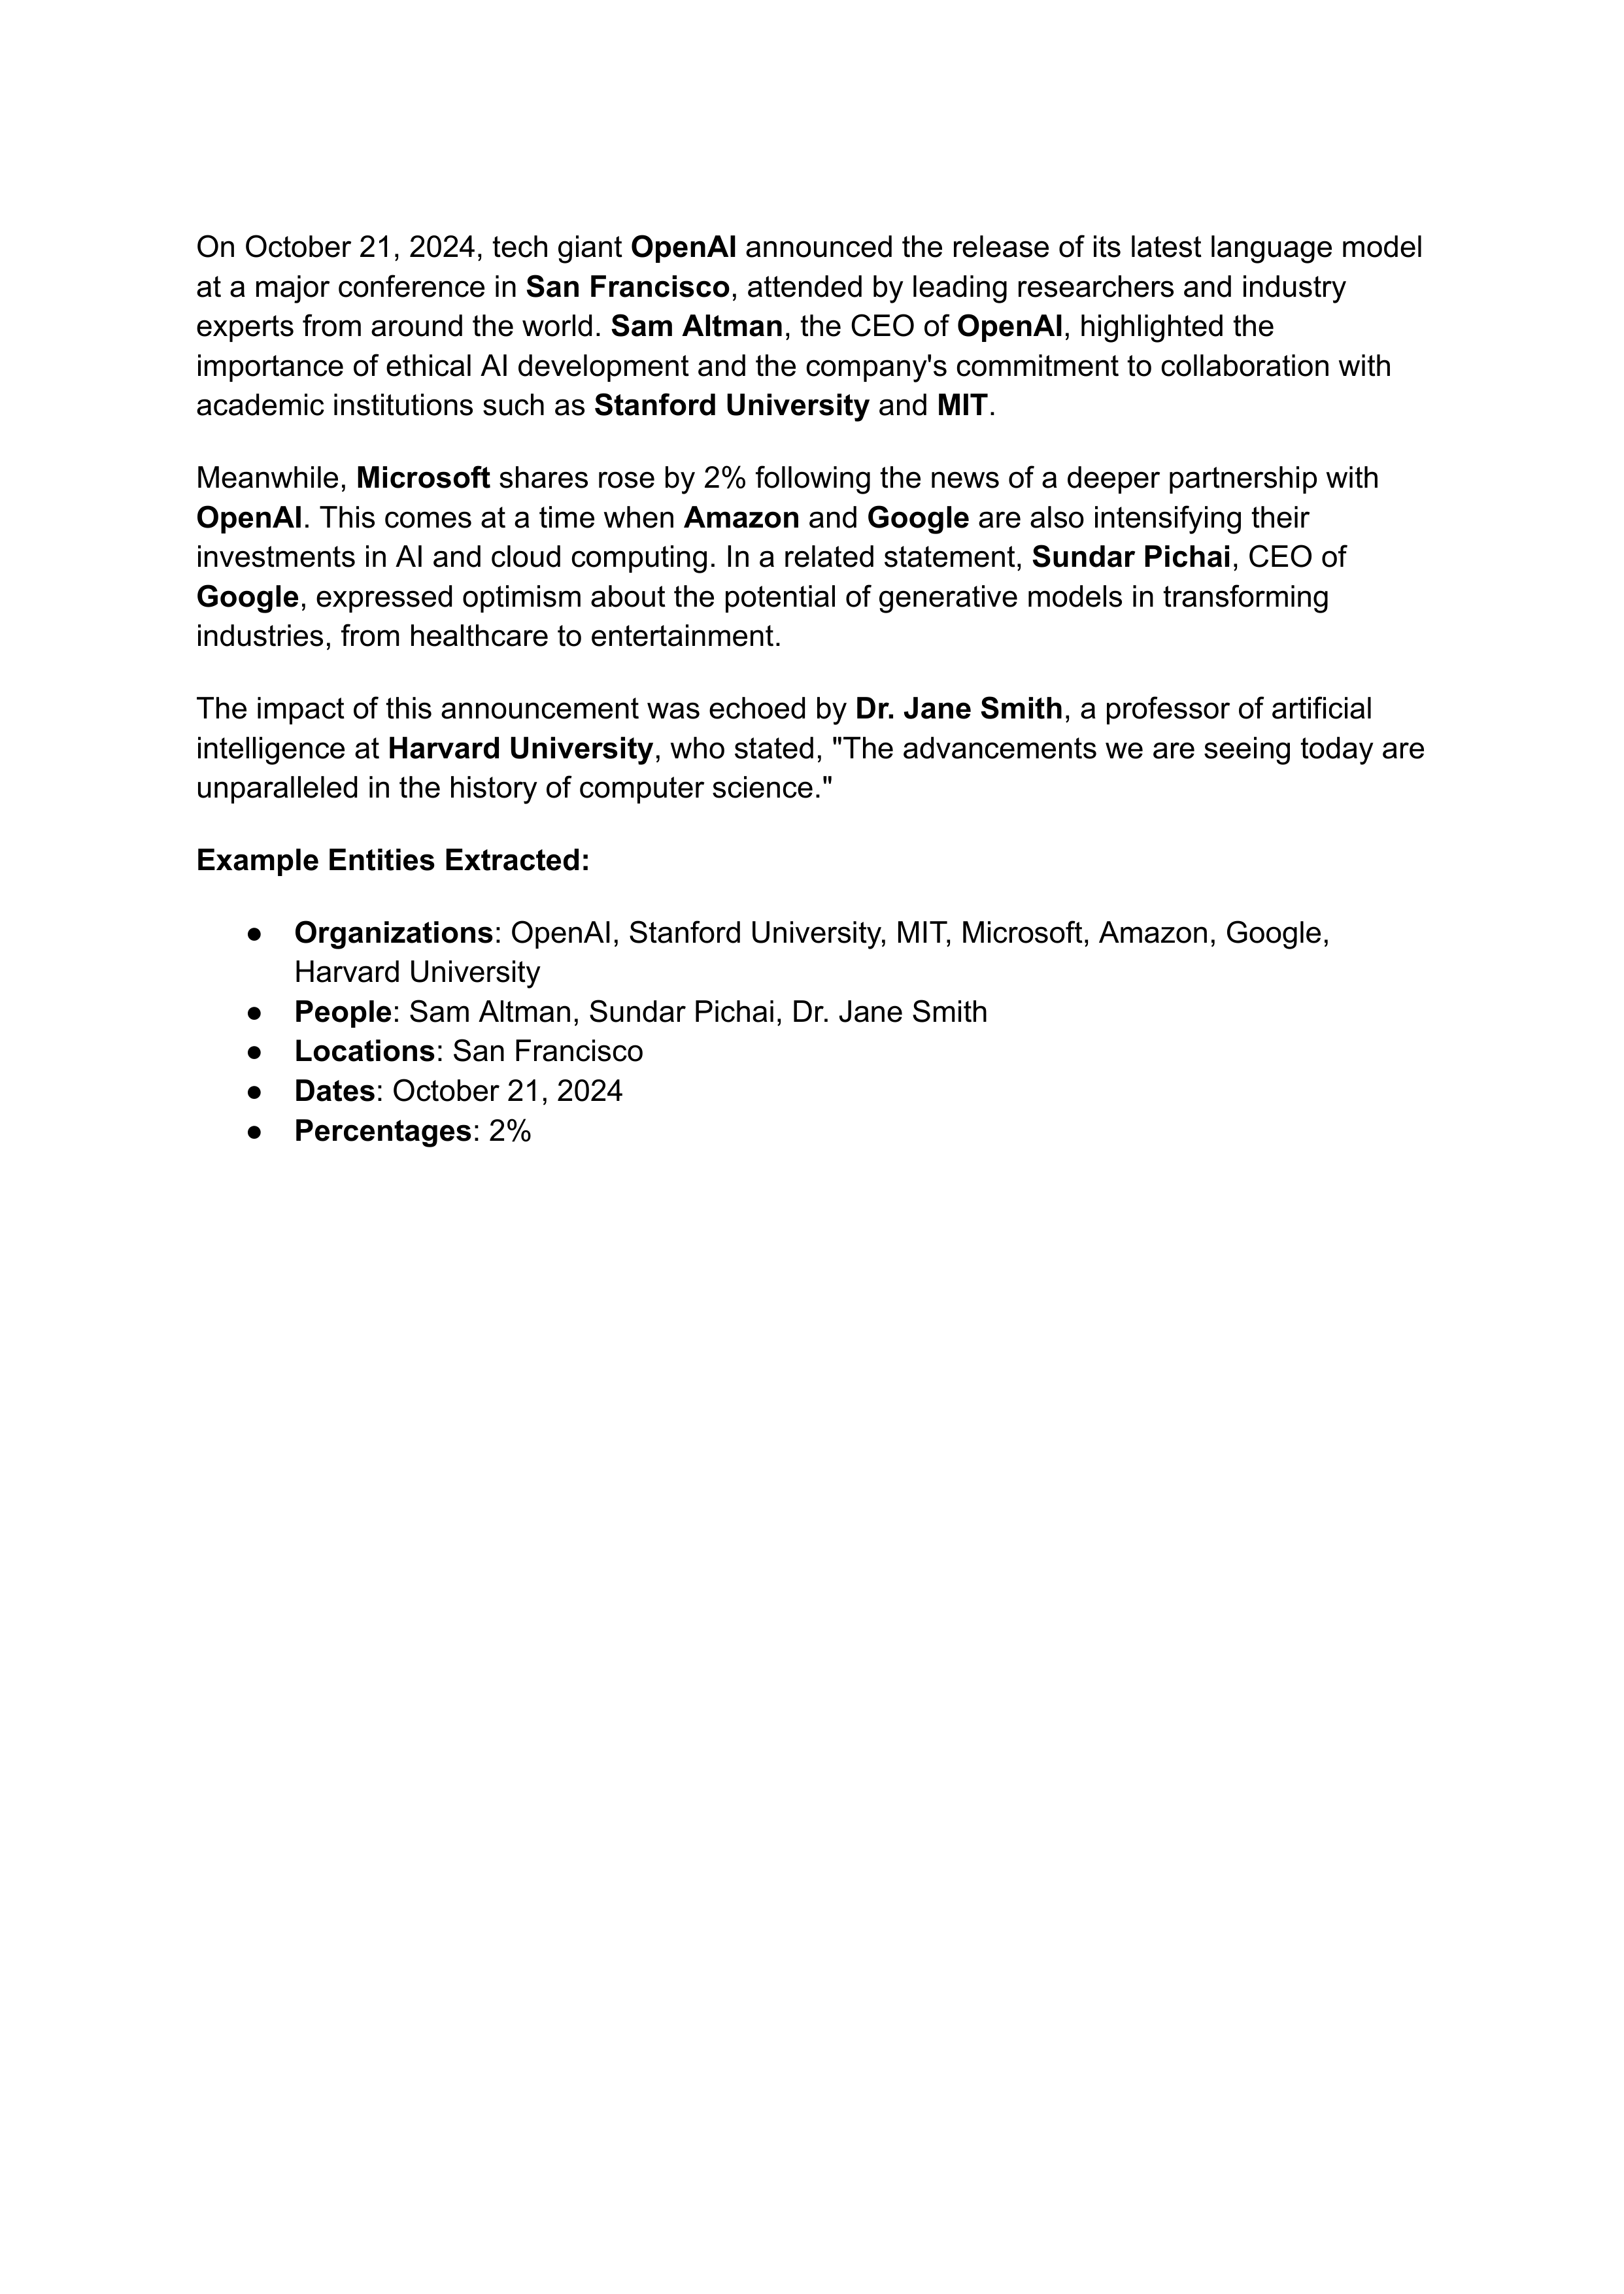

In [8]:
pdf_df = spark.read.format("binaryFile").load("./data/pdfs/example.pdf")

pdf_df.show_pdf()

## Run Ner for Pdf document

In [10]:
pipeline = PipelineModel(stages=[
    PdfDataToImage(),
    TesseractOcr(keepInputData=True),
    LLMNer(model="gemini-1.5-flash-8b"),
    ImageDrawBoxes(inputCols=["image", "ner"], displayDataList=["entity_group", "score"],
                   textSize=20, lineWidth=3)
])

result = pipeline.transform(pdf_df).cache()

result.show_ner("ner")

[Stage 11:>                                                         (0 + 1) / 1]

+------------+-----+-------------------+-----+---+--------------------+
|entity_group|score|               word|start|end|               boxes|
+------------+-----+-------------------+-----+---+--------------------+
|ORGANIZATION|  0.0|             OpenAl|    0|  0|[{OpenAl, 0.90604...|
|ORGANIZATION|  0.0|Stanford University|    0|  0|[{Stanford, 0.958...|
|ORGANIZATION|  0.0|                MIT|    0|  0|[{commitment, 0.9...|
|ORGANIZATION|  0.0|          Microsoft|    0|  0|[{Microsoft, 0.96...|
|ORGANIZATION|  0.0|             Amazon|    0|  0|[{Amazon, 0.96250...|
|ORGANIZATION|  0.0|             Google|    0|  0|[{Google, 0.95917...|
|ORGANIZATION|  0.0| Harvard University|    0|  0|[{University, 0.9...|
|      PERSON|  0.0|         Sam Altman|    0|  0|[{Sam, 0.96484108...|
|      PERSON|  0.0|      Sundar Pichai|    0|  0|[{Sundar, 0.93173...|
|      PERSON|  0.0|     Dr. Jane Smith|    0|  0|[{Dr., 0.96427933...|
|    LOCATION|  0.0|      San Francisco|    0|  0|[{San, 0.95567

## Visualize Ner results on original image

Image#:,0
Path:,example.pdf
Size:,2484 x 3509 px
Resolution:,300 dpi

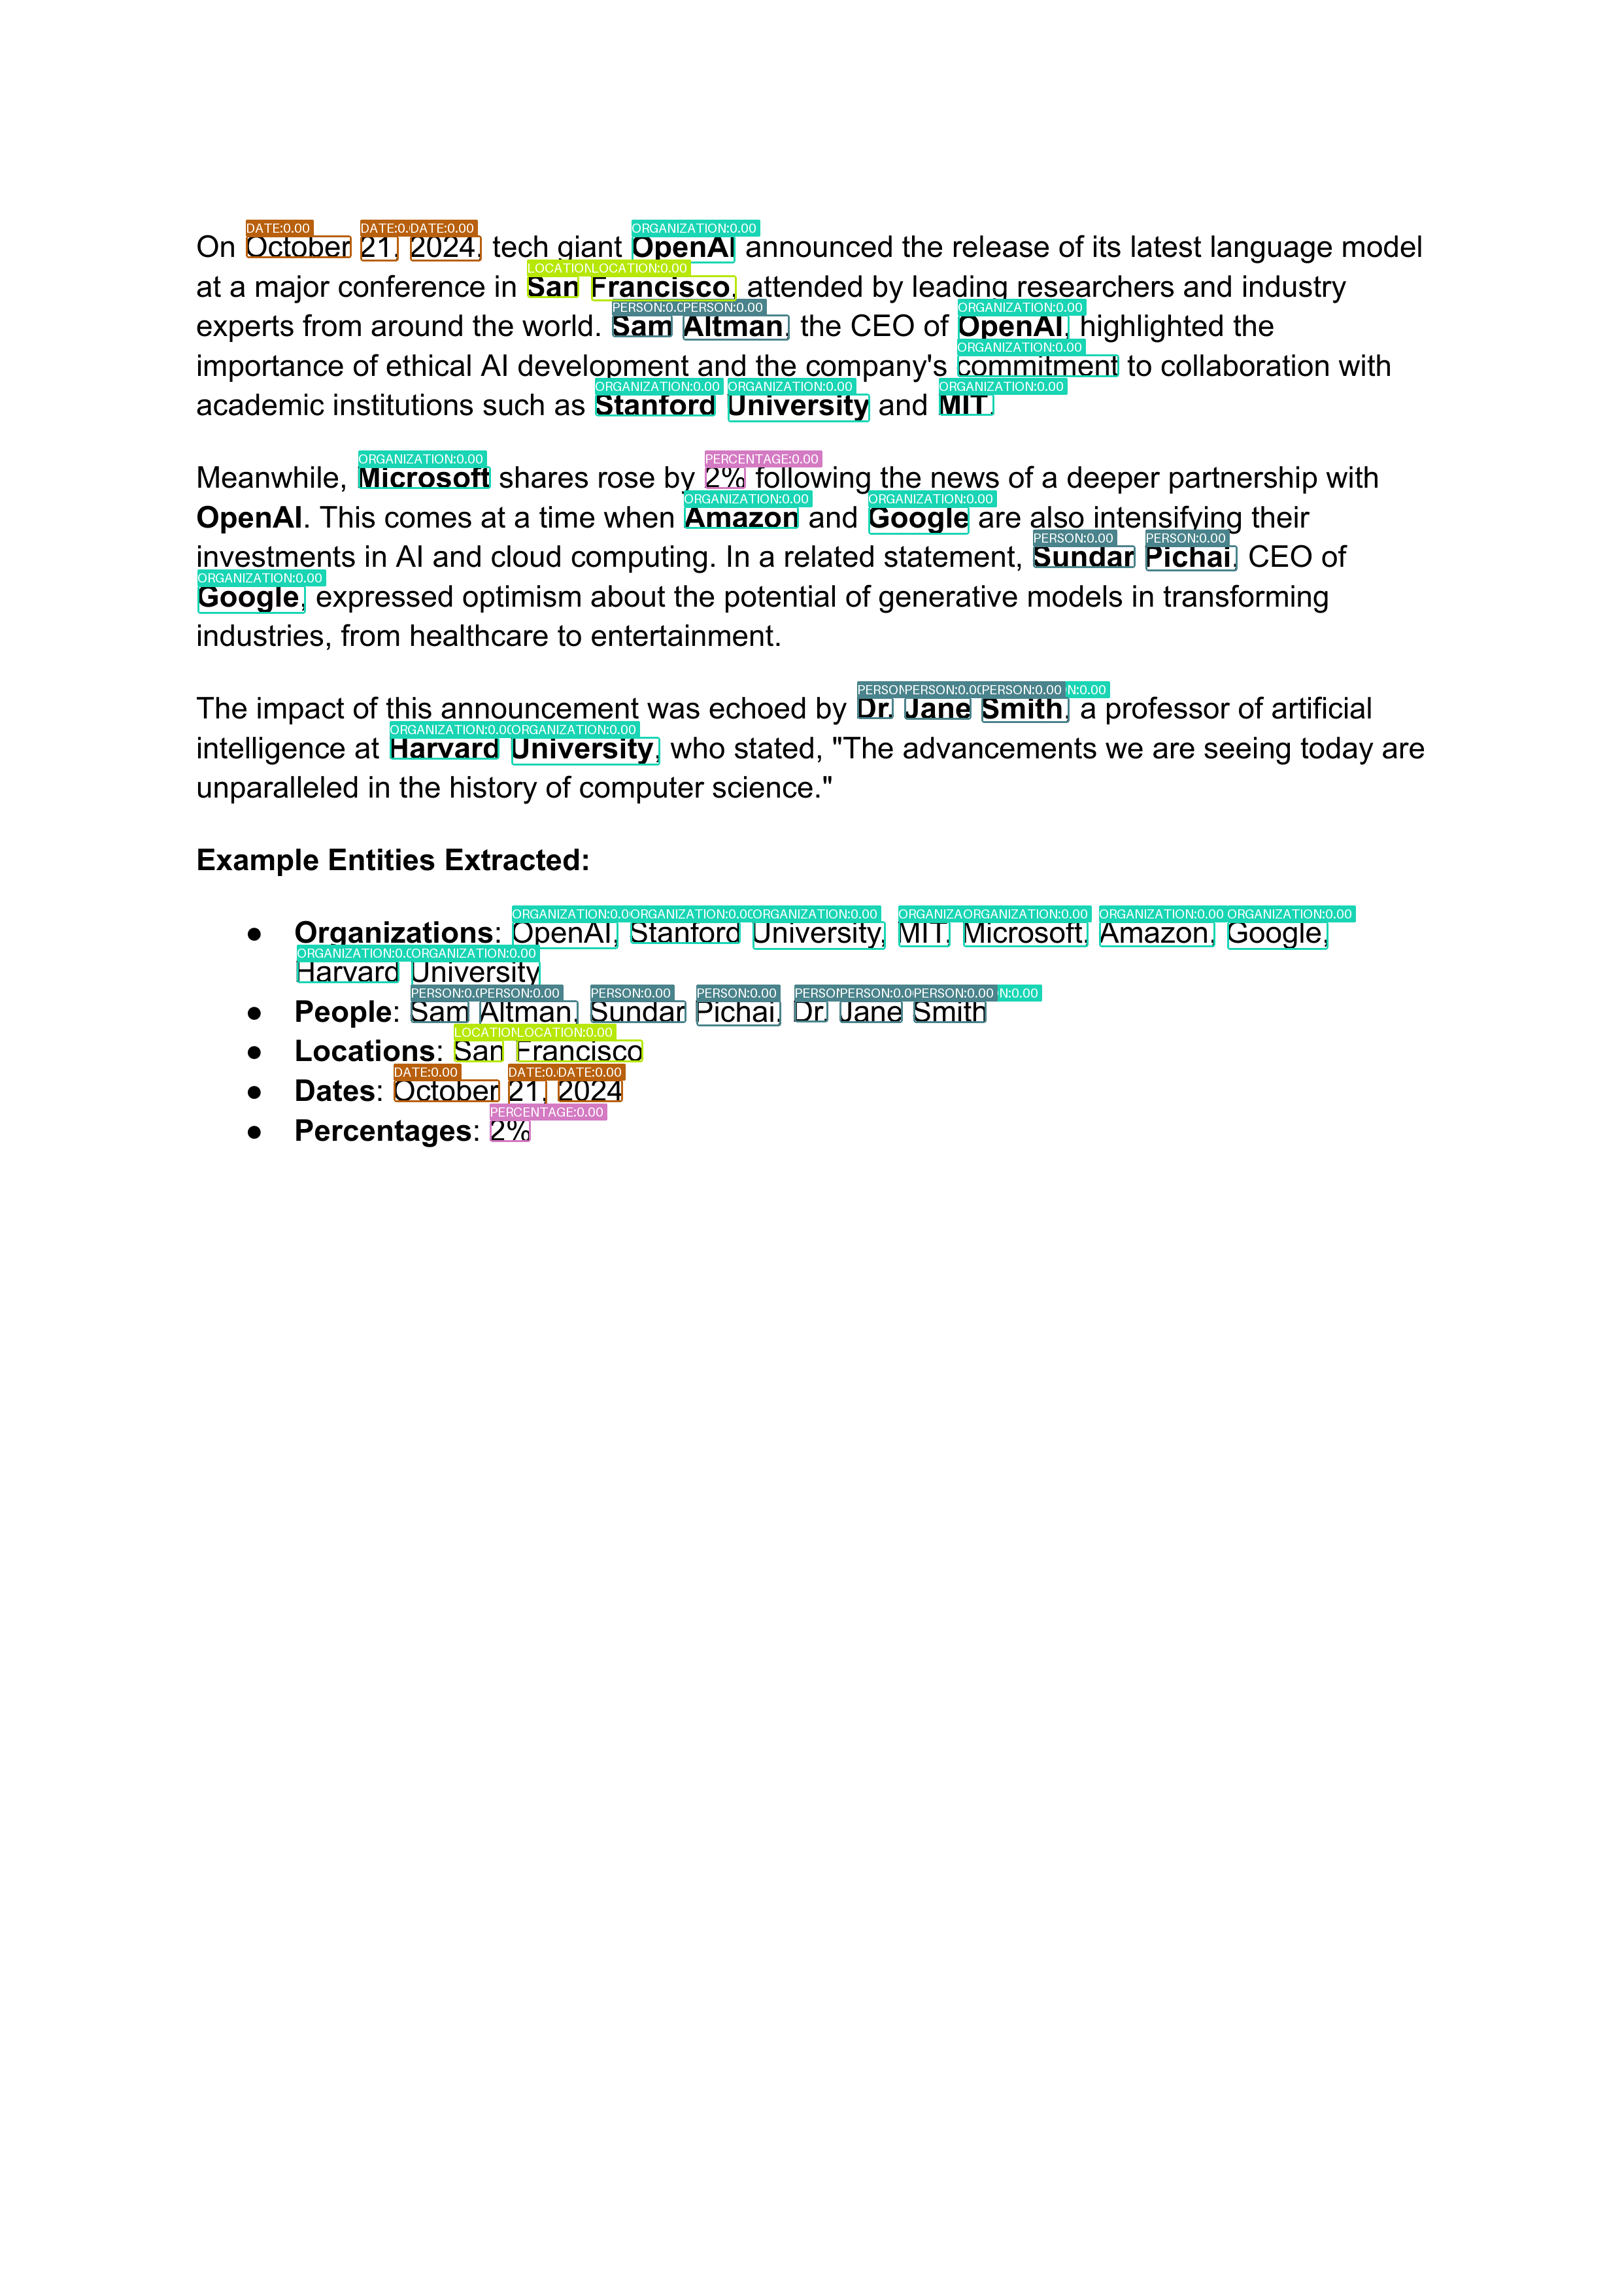

In [11]:
result.show_image("image_with_boxes")